<a href="https://colab.research.google.com/github/akshithpt109/seismic_detection/blob/main/Seismic_quake_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

In [2]:
!pip install obspy

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


df = pd.read_csv("/content/Features_New_Expanded.csv")

#df = df.drop(columns=['filename', 'event_duration'])
df = df.dropna(axis=1)
df

,arrival,max_sta_lta,max_sta_lta_time,mean_sta_lta,var_sta_lta,mean_amp,max_amp,max_amp_time,second_max_amp,second_max_amp_time,min_amp,min_amp_time,rms_amp,energy_threshold_time,sta_lta_start_time,sta_lta_end_time
0,73499.335,2.374340,37625.811321,1.015039,0.326191,2.723003e-20,7.168520e-09,73991.547170,6.700034e-09,73910.943396,-7.097313e-09,73990.943396,3.000852e-10,114.566038,474.716981,882.867925
1,12719.560,2.295762,16873.962264,0.995377,0.039389,2.426280e-21,4.337924e-09,13448.905660,4.200714e-09,13575.396226,-4.348940e-09,13449.509434,2.318099e-10,107.773585,474.716981,1021.283019
2,73019.435,2.374340,24264.150943,0.998502,0.096869,1.216101e-20,5.446156e-09,73572.377358,4.957813e-09,73571.169811,-5.906712e-09,73571.773585,2.508909e-10,115.471698,474.716981,1388.226415
3,4439.804,2.310864,474.867925,0.994062,0.077505,-4.978128e-21,6.482011e-09,5300.679245,6.272693e-09,5301.886792,-6.443661e-09,5301.283019,2.935849e-10,111.547170,474.716981,1627.018868
4,52139.340,2.296394,474.716981,0.993744,0.050529,-3.539701e-22,3.570016e-09,52970.113208,3.569771e-09,52405.283019,-3.922370e-09,52514.264151,2.289006e-10,113.811321,474.716981,1026.264151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,63779.004,2.374246,1219.773585,1.001939,0.458038,1.885967e-23,5.891982e-09,64182.943396,5.762565e-09,64357.283019,-6.044107e-09,64491.471698,2.325307e-10,94.641509,474.716981,818.867925
71,65699.813,2.363714,696.754717,0.998241,0.258681,-1.125688e-20,5.288960e-08,66322.566038,5.157103e-08,66322.415094,-4.998219e-08,66220.377358,1.837439e-09,101.886792,537.509434,944.603774
72,36299.543,2.369645,36504.754717,0.989006,0.034921,3.310777e-23,1.034582e-07,37448.301887,9.815816e-08,37443.773585,-1.041873e-07,37447.698113,3.437509e-09,113.811321,474.716981,1996.679245
73,57779.761,2.373947,723.924528,0.998972,0.174482,-6.691174e-21,6.624310e-09,57892.226415,6.442783e-09,57892.377358,-6.706438e-09,57891.773585,1.961781e-10,48.754717,474.716981,940.075472


In [4]:
from sklearn.preprocessing import StandardScaler

features_df_clean = df.drop(columns=['arrival'])


# Standardize features (zero mean and unit variance)
scaler = StandardScaler()
features_df_scaled = scaler.fit_transform(features_df_clean)

In [5]:
from sklearn.model_selection import train_test_split

# Define the target variable (relative time or absolute time)
X = features_df_scaled  # All features
y_absolute = df['arrival']  # relative time (target)
# Split the data for absolute time prediction
X_train_abs, X_test_abs, y_train_abs, y_test_abs = train_test_split(X, y_absolute, test_size=0.2, random_state=42)

In [6]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(n_estimators=200, random_state=42)
lgb_model.fit(X_train_abs, y_train_abs)
y_pred_lgb = lgb_model.predict(X_test_abs)

print(f"MAE LightGBM: {mean_absolute_error(y_test_abs, y_pred_lgb)}")
print(f"R^2 LightGBM: {r2_score(y_test_abs, y_pred_lgb)}")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 14
[LightGBM] [Info] Start training from score 42288.583388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [7]:

# Set up the RandomForest Regressor
rf_model_abs = RandomForestRegressor(n_estimators=200, random_state=42)
# Train the model on absolute time prediction
rf_model_abs.fit(X_train_abs, y_train_abs)

# Predict on the test set
y_pred_abs = rf_model_abs.predict(X_test_abs)

# Evaluate the model performance
mae_abs = mean_absolute_error(y_test_abs, y_pred_abs)
r2_abs = r2_score(y_test_abs, y_pred_abs)

print(f'Mean Absolute Error (Absolute Time): {mae_abs}')
print(f'R^2 Score (Absolute Time): {r2_abs}')

Mean Absolute Error (Absolute Time): 6568.835698380947
R^2 Score (Absolute Time): 0.5587852807638374


In [8]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# List of models to evaluate
models = [
    ("RandomForest", RandomForestRegressor(n_estimators=200, random_state=42)),
    ("GradientBoosting", GradientBoostingRegressor(n_estimators=200, random_state=42)),
    ("AdaBoost", AdaBoostRegressor(n_estimators=200, random_state=42)),
    ("DecisionTree", DecisionTreeRegressor(random_state=42)),
    ("KNeighbors", KNeighborsRegressor(n_neighbors=5)),
    ("XGBoost", XGBRegressor(n_estimators=200, random_state=42))
]

# Loop through models, train, predict and evaluate
for name, model in models:
    # Train the model
    model.fit(X_train_abs, y_train_abs)

    # Predict on the test set
    y_pred_abs = model.predict(X_test_abs)

    # Evaluate the model performance
    mae_abs = mean_absolute_error(y_test_abs, y_pred_abs)
    r2_abs = r2_score(y_test_abs, y_pred_abs)

    # Print the results
    print(f'{name}:')
    print(f'  Mean Absolute Error (Absolute Time): {mae_abs}')
    print(f'  R^2 Score (Absolute Time): {r2_abs}')
    print('-' * 40)


RandomForest:
  Mean Absolute Error (Absolute Time): 6568.835698380947
  R^2 Score (Absolute Time): 0.5587852807638374
----------------------------------------
GradientBoosting:
  Mean Absolute Error (Absolute Time): 6388.659050635513
  R^2 Score (Absolute Time): 0.5796331960726455
----------------------------------------
AdaBoost:
  Mean Absolute Error (Absolute Time): 7674.118692486772
  R^2 Score (Absolute Time): 0.4996401193012773
----------------------------------------
DecisionTree:
  Mean Absolute Error (Absolute Time): 8256.0838
  R^2 Score (Absolute Time): 0.5011900738753344
----------------------------------------
KNeighbors:
  Mean Absolute Error (Absolute Time): 8796.710186666669
  R^2 Score (Absolute Time): 0.6797758634262254
----------------------------------------
XGBoost:
  Mean Absolute Error (Absolute Time): 7706.613940104166
  R^2 Score (Absolute Time): 0.5355932593357245
----------------------------------------


In [9]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Define the base models (as tuples of name and model)
base_models = [
    ('random_forest', RandomForestRegressor(n_estimators=200, random_state=42)),
    ('xgboost', XGBRegressor(n_estimators=200, random_state=42)),
    ('adaboost', AdaBoostRegressor(n_estimators=200, random_state=42)),
    ('knn', KNeighborsRegressor(n_neighbors=5))
]

# Define the meta-model (or final estimator)
meta_model = LinearRegression()

# Create the Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Train the stacking model
stacking_model.fit(X_train_abs, y_train_abs)

# Predict on the test set using the stacking model
y_pred_abs = stacking_model.predict(X_test_abs)

# Evaluate the model performance
mae_abs = mean_absolute_error(y_test_abs, y_pred_abs)
r2_abs = r2_score(y_test_abs, y_pred_abs)

# Print the results
print('Stacking Regressor:')
print(f'Mean Absolute Error (Absolute Time): {mae_abs}')
print(f'R^2 Score (Absolute Time): {r2_abs}')


Stacking Regressor:
Mean Absolute Error (Absolute Time): 6139.324796249533
R^2 Score (Absolute Time): 0.6588336766364395


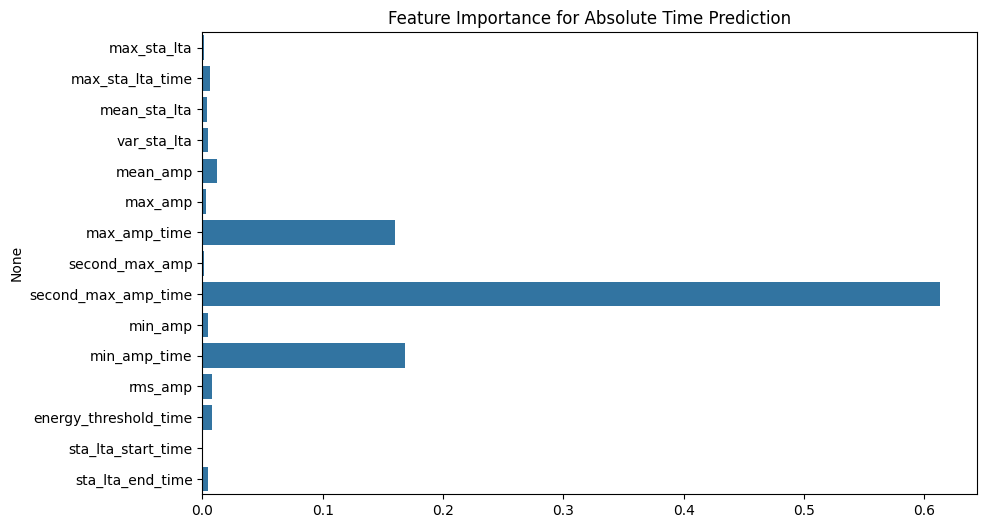

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
importances = rf_model_abs.feature_importances_
feature_names = features_df_clean.columns

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance for Absolute Time Prediction')
plt.show()

In [11]:
from catboost import CatBoostRegressor

catboost_model = CatBoostRegressor(iterations=200, learning_rate=0.1, random_state=42)
catboost_model.fit(X_train_abs, y_train_abs)

y_pred_catboost = catboost_model.predict(X_test_abs)
r2_catboost = r2_score(y_test_abs, y_pred_catboost)
print(f"CatBoost R^2: {r2_catboost}")

0:	learn: 24763.8883878	total: 49.5ms	remaining: 9.85s
1:	learn: 23571.9768991	total: 52.7ms	remaining: 5.22s
2:	learn: 22568.0031773	total: 54.2ms	remaining: 3.56s
3:	learn: 21523.9899301	total: 55.7ms	remaining: 2.73s
4:	learn: 20690.9630209	total: 58.5ms	remaining: 2.28s
5:	learn: 19748.5621884	total: 61.3ms	remaining: 1.98s
6:	learn: 18890.6416622	total: 64.1ms	remaining: 1.77s
7:	learn: 18336.4907290	total: 66.8ms	remaining: 1.6s
8:	learn: 17656.4283304	total: 69.5ms	remaining: 1.48s
9:	learn: 16934.8004084	total: 72.1ms	remaining: 1.37s
10:	learn: 16279.4468320	total: 75.4ms	remaining: 1.29s
11:	learn: 15667.7747523	total: 77.2ms	remaining: 1.21s
12:	learn: 15081.3175314	total: 79.8ms	remaining: 1.15s
13:	learn: 14577.7201528	total: 82.3ms	remaining: 1.09s
14:	learn: 13866.7887936	total: 84.9ms	remaining: 1.05s
15:	learn: 13471.7582595	total: 87.4ms	remaining: 1s
16:	learn: 13088.7034501	total: 89.9ms	remaining: 968ms
17:	learn: 12548.1236125	total: 92.4ms	remaining: 934ms
18:	le

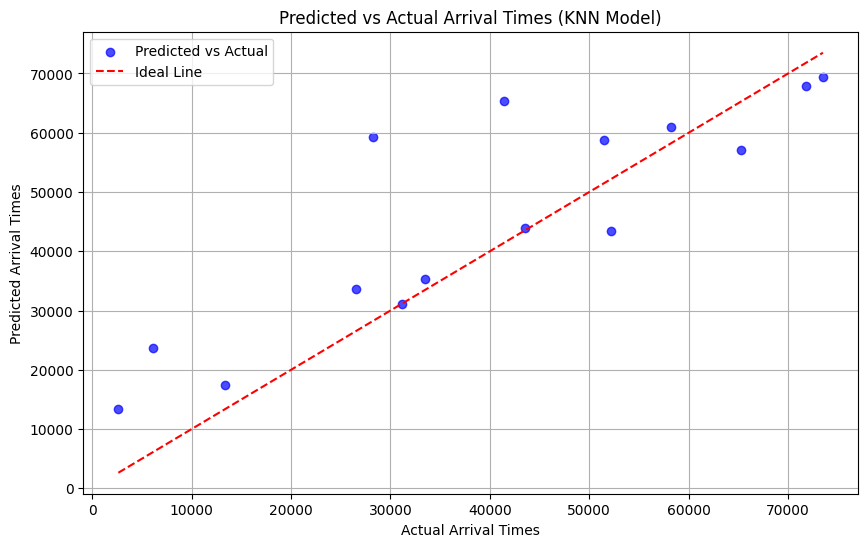

In [12]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

# Train the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_abs, y_train_abs)

# Predict using the KNN model
y_pred_knn = knn_model.predict(X_test_abs)

# Plot the actual vs predicted arrivals for the KNN model
plt.figure(figsize=(10, 6))
plt.scatter(y_test_abs, y_pred_knn, alpha=0.7, color='b', label='Predicted vs Actual')
plt.plot([min(y_test_abs), max(y_test_abs)], [min(y_test_abs), max(y_test_abs)], color='red', linestyle='--', label='Ideal Line')

# Adding legend
plt.legend()

plt.title("Predicted vs Actual Arrival Times (KNN Model)")
plt.xlabel("Actual Arrival Times")
plt.ylabel("Predicted Arrival Times")
plt.grid(True)
plt.show()

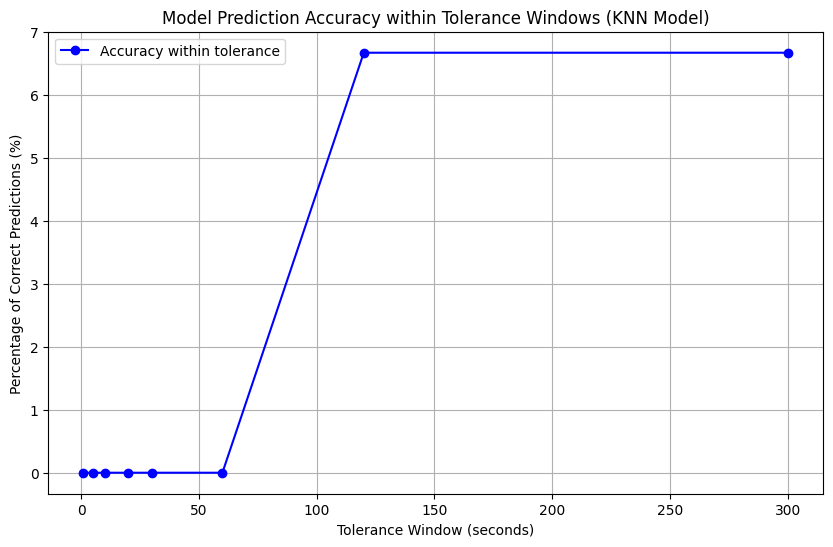

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define tolerance windows (in seconds)
tolerance_windows = [1, 5, 10, 20, 30, 60, 120, 300]

# Calculate percentage of predictions within each tolerance window
percentages = []
for tol in tolerance_windows:
    within_window = np.abs(y_test_abs - y_pred_knn) <= tol
    percentage = np.mean(within_window) * 100  # Convert to percentage
    percentages.append(percentage)

# Plot the percentage accuracy for each tolerance window
plt.figure(figsize=(10, 6))
plt.plot(tolerance_windows, percentages, marker='o', color='b', label='Accuracy within tolerance')
plt.title("Model Prediction Accuracy within Tolerance Windows (KNN Model)")
plt.xlabel("Tolerance Window (seconds)")
plt.ylabel("Percentage of Correct Predictions (%)")
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


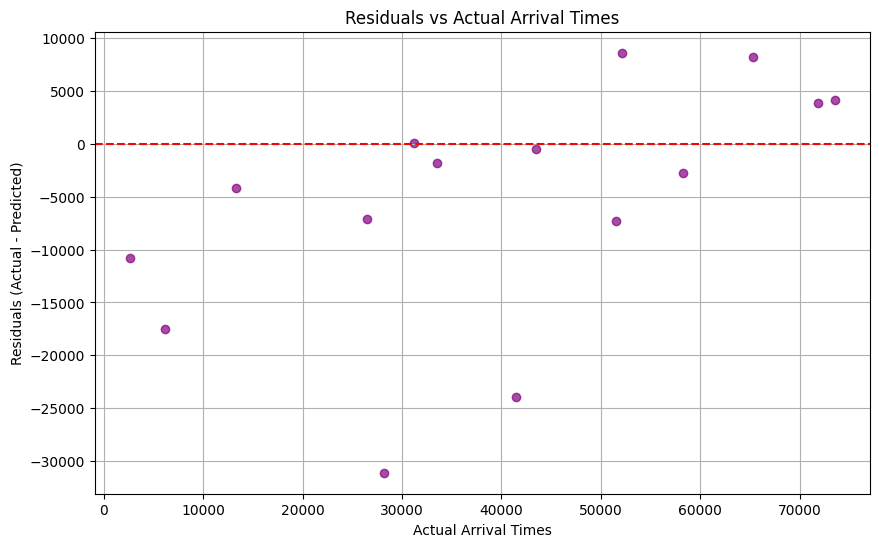

In [15]:
residuals = y_test_abs - y_pred_knn

plt.figure(figsize=(10, 6))
plt.scatter(y_test_abs, residuals, alpha=0.7, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Actual Arrival Times")
plt.xlabel("Actual Arrival Times")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.show()

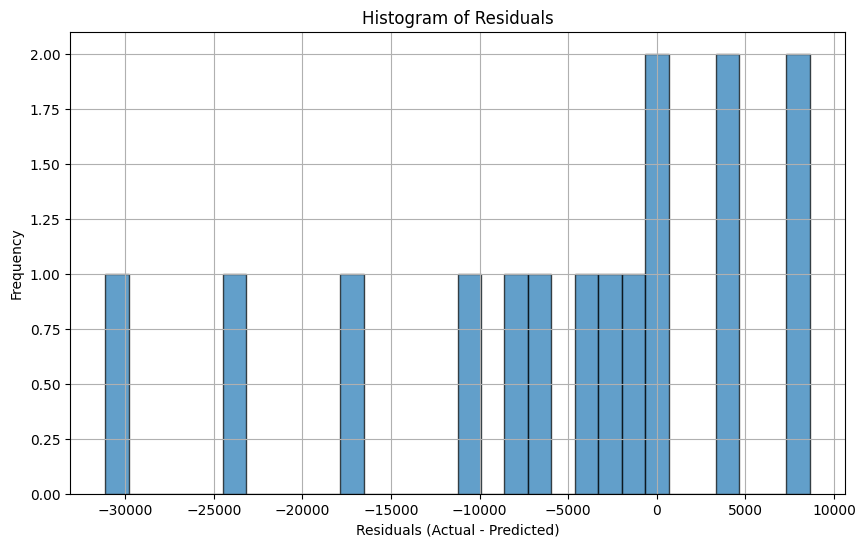

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [18]:
import os
import pandas as pd
from obspy import read
from datetime import datetime

folder_path = '/content/drive/MyDrive/LunarTestingData'
mseed_files = [f for f in os.listdir(folder_path) if f.endswith('.mseed')]